**Wiktor Ligęza, Inżynieria Obliczeniowa, gr.2**  
**Data: 06/11/2021**   
**Projekt Zaliczeniowy**  
**Temat: Usuwanie szumów periodycznych z obrazów cyfrowych za pomocą filtrów w dziedzinie częstotliwości** 

In [1]:
from scipy import fftpack
import matplotlib.pyplot as plt
import numpy.fft as fp
import numpy as np
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import cv2
from skimage.io import imread, imshow
import warnings
from scipy.ndimage import convolve
import scipy.stats as st

### Funkcje

In [72]:
def paint_square(arr, x, y, n):
    for i in range(-n, n):
        for j in range(-n, n):
            arr[x+i][y+j] = 0
    return arr


def insert_at(big, pos, small):
    x1 = pos[0]
    y1 = pos[1]
    x2 = x1 + small.shape[0]
    y2 = y1 + small.shape[1]
    assert x2  <= big.shape[0], "the position will make the small matrix exceed the boundaries at x"
    assert y2  <= big.shape[1], "the position will make the small matrix exceed the boundaries at y"
    big[x1:x2,y1:y2] = small
    return big

def paint_gaussian(kernel ,v2, v1, n, nsig=3):
    arr_gauss = get_gaussian(kernlen=n, nsig=nsig)
    arr_gauss *= 1/arr_gauss.max()
    arr_gauss = 1-arr_gauss
    return insert_at(kernel, (v2-int(n/2), v1-int(n/2)), arr_gauss)


def get_gaussian(kernlen=20, nsig=3):
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()


def get_binarized(img, th=125, type_="GAUSSIAN"):
    return 255*(img > th)


def get_dots(img, org, squer_size, type_="GAUSSIAN", nsig=1):
    kernel = np.ones((img.shape))
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)
        v1 = (x + w / 2)
        v2 = (y + h / 2)
        try:
            if type_ == "GAUSSIAN":
                paint_gaussian(kernel , round(v2), round(v1), squer_size, nsig)
            else:
                paint_square(kernel , round(v2), round(v1), n=squer_size)
        except Exception as e:
                print(str(e))
    return kernel


def dilatation(img, n=4):
    for i in range(n):
        img = ndimage.binary_dilation(img)
    return img


def scale(spectrum, log_rep=True):
    arr_ = spectrum.copy()
    if log_rep:
        arr_ = (np.log10( 0.1 + arr_)).astype('float64')
    arr_ *= 255/arr_.max()
    return np.round(arr_)


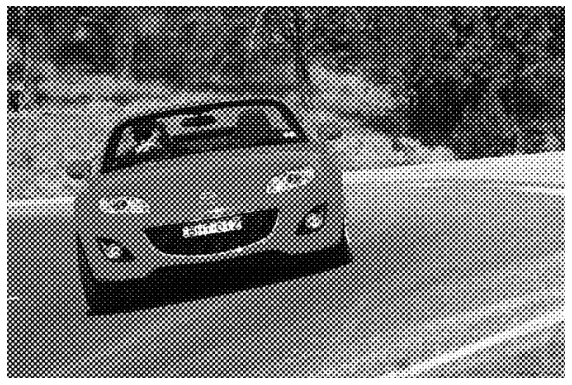

In [73]:
im = imread('halftone.png')
plt.figure(figsize=(10,10));
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

## 1 
użycie transforamty Fouriera w celu uzyskania spektrum częstotliwości obrazu, oraz wyśrodkowanie spektrum

In [79]:
F1 = fftpack.fft2((im).astype(float))
F2 = fftpack.fftshift(F1)
F2_abs = np.abs(F2.copy())

In [80]:
F2_abs.dtype

dtype('float64')

In [ ]:
F1 = fftpack.fft2((im).astype(float))
F2 = fftpack.fftshift(F1)
F2_abs = np.abs(F2.copy())
max_ = np.max(F2_abs)
F2_gauss = gaussian_filter(F2_abs.copy(), 0.5)
th_F2 = get_binarized(F2_gauss, th=max_*0.005)
center_point = np.array(im.shape)/2
th_F2 = paint_square(th_F2, int(center_point[0]),  int(center_point[1]), n=int(center_point[1]*0.3))
th_F2_dilt = dilatation(th_F2, n=3)
_, th_F2_dilt = cv2.threshold(np.float32(th_F2_dilt), 0, 255, cv2.THRESH_BINARY)
kernel = get_dots(th_F2_dilt.astype('uint8'), F2_abs, squer_size=40, type_="GAUSSIAN", nsig=1)
log_rep = scale(F2_abs)

## 2 
usuwanie obszarów o wysokiej częstotliwości - prawdopodobnie one są odpowiedzialne za szum   
względem tego stworzyłem funkcje szukające obszarów o podwyższonej częstotliwości a następnie usuwające je

##### gauss dla sigma = 3

0.0 1.0


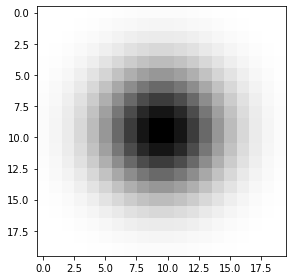

In [403]:
arr_gauss_ = get_gaussian(kernlen=20, nsig=3)
arr_gauss_ *= 1/arr_gauss_.max()
arr_gauss_ = 1-arr_gauss_
imshow(arr_gauss_);
print(round(arr_gauss_.min(), 3), round(arr_gauss_.max(), 3))

##### gauss dla sigma = 1

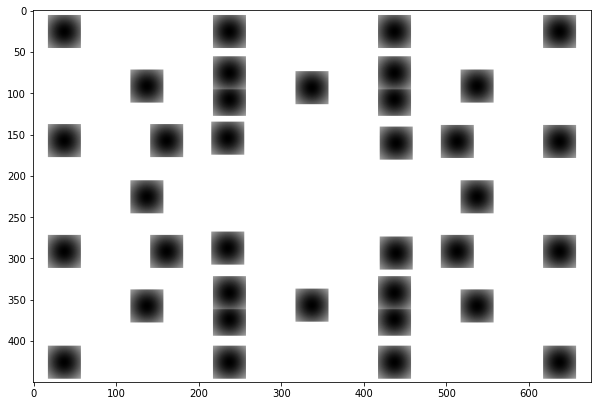

In [404]:
plt.figure(figsize=(10,10));
plt.imshow(kernel, cmap='gray');
plt.show();   

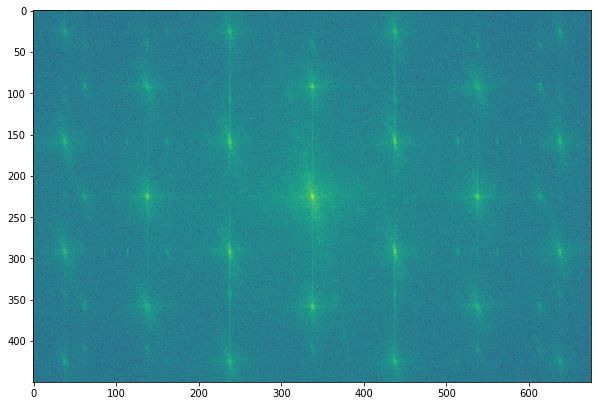

In [406]:
plt.figure(figsize=(10,10));
plt.imshow(log_rep)
plt.show();   

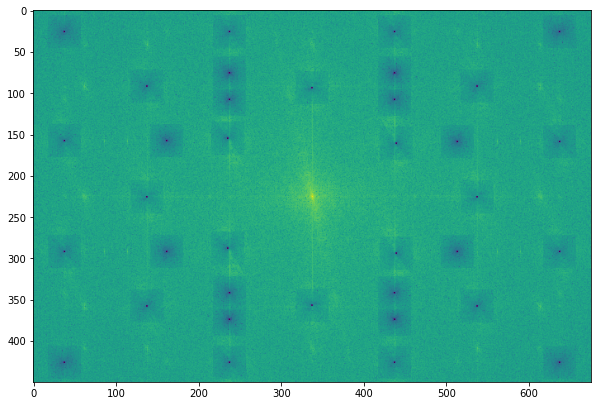

In [407]:
F2_conv = F2*kernel
plt.figure(figsize=(10,10));
plt.imshow(scale(abs(F2_conv)))
plt.show();   

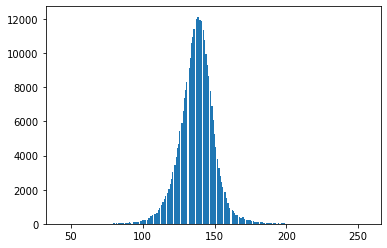

In [408]:
plt.hist(scale(F2_abs).ravel(),bins=255);

## 3
Użycie odwróconej transofmaty Fouriera w celu powrotu do domeny przestreznnej obrazu

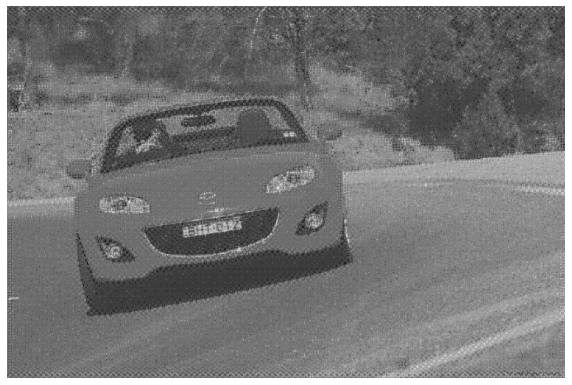

In [409]:
im1 = fp.ifft2(fftpack.ifftshift(F2_conv)).real
plt.figure(figsize=(10,10))
plt.imshow(im1, cmap='gray')
plt.axis('off')
plt.show()

### zdjęci oryginalne

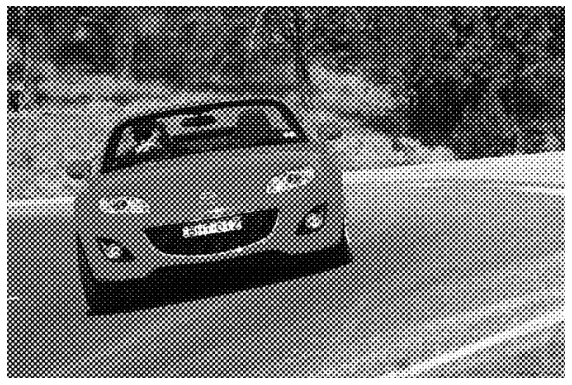

In [410]:
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

### Testowanie Funckji dla 3 przykłądów:

In [17]:
def plot(im,clean,F, mask):
    fig, axs = plt.subplots(1 ,4)
    axs[0].imshow(im, cmap='gray');
    axs[0].set_title('org')
    axs[1].imshow(clean, cmap='gray');
    axs[1].set_title('clean')
    axs[2].imshow(F);
    axs[2].set_title('F');
    axs[3].imshow(mask);
    axs[3].set_title('mask');
    fig.set_size_inches(18.5, 10.5);
    fig.tight_layout(pad=5.0)

In [50]:
def periodic_denosier(im, th=0.005, r=0.3, squer_size = 7, nsig=1):
    F1 = fftpack.fft2((im).astype(float))
    F2 = fftpack.fftshift(F1)
    F2_abs = np.abs(F2.copy())
    max_ = np.max(F2_abs)
    F2_gauss = gaussian_filter(F2_abs.copy(), 0.5)
    th_F2 = get_binarized(F2_gauss, th=max_*th)
    center_point = np.array(im.shape)/2
    th_F2 = paint_square(th_F2, int(center_point[0]),  int(center_point[1]), n=int(center_point[1]*r))
    th_F2_dilt = dilatation(th_F2, n=3)
    _, th_F2_dilt = cv2.threshold(np.float32(th_F2_dilt), 0, 255, cv2.THRESH_BINARY)
    kernel = get_dots(th_F2_dilt.astype('uint8'), F2_abs, squer_size=squer_size, type_="GAUSSIAN", nsig=nsig)
    log_rep = scale(F2_abs)
    F2_conv = F2*kernel
    im1 = fp.ifft2(fftpack.ifftshift(F2_conv)).real
    plot(im,im1,log_rep, scale(abs(F2_conv)))
    return im1

In [40]:
# def periodic_denosier(im, th=0.001, r=0.3, squer_size = 7):
#     F1 = fftpack.fft2((im).astype(float))
#     F2 = fftpack.fftshift(F1)
#     max_ = np.max(F2)
#     F2_gauss = gaussian_filter(F2.copy(), 0.5)
#     th_F2 = get_binarized(F2_gauss, th=max_*0.005)
#     center_point = np.array(im.shape)/2
#     th_F2 = paint_square(th_F2, int(center_point[0]),  int(center_point[1]), n=int(center_point[1]*r))
#     th_F2_dilt = dilatation(th_F2, n=3)
#     _, th_F2_dilt = cv2.threshold(np.float32(th_F2_dilt), 0, 255, cv2.THRESH_BINARY)
#     F2 = get_dots(th_F2_dilt.astype('uint8'), F2, squer_size)
#     log_rep = (20*np.log10( 0.1 + F2)).astype(int);
#     im1 = fp.ifft2(fftpack.ifftshift(F2)).real
#     plot(im,im1,log_rep)
#     return im1
    

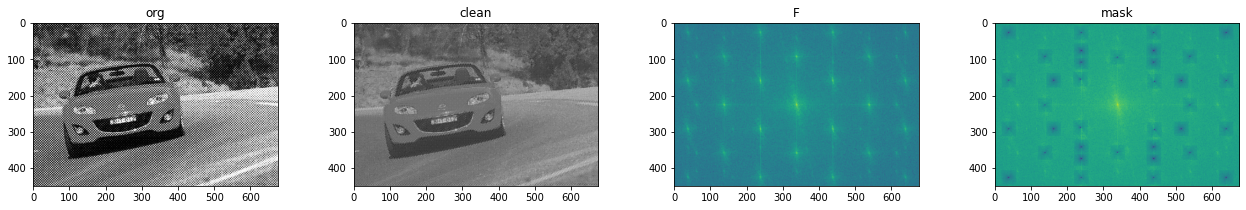

In [41]:
im = imread('halftone.png')
imf = periodic_denosier(im, squer_size=40)

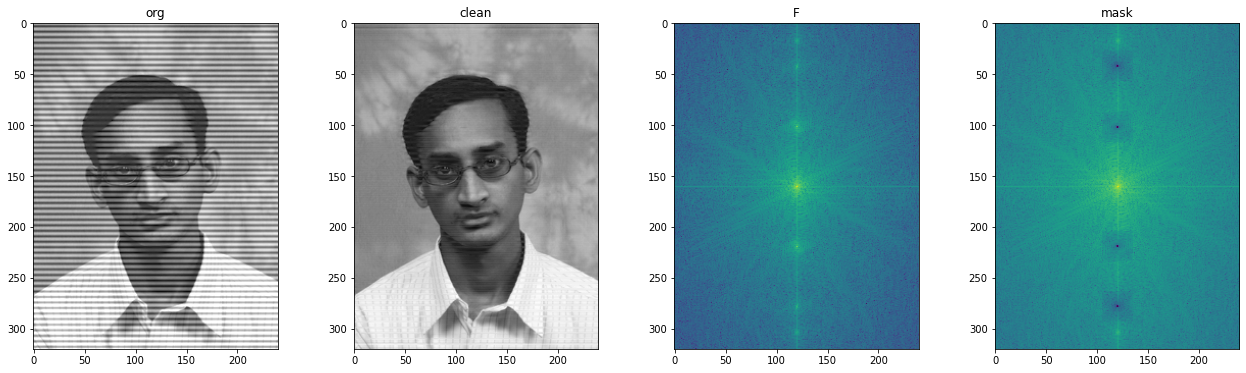

In [42]:
im = imread('ex2.png')
imf = periodic_denosier(im, squer_size=30)

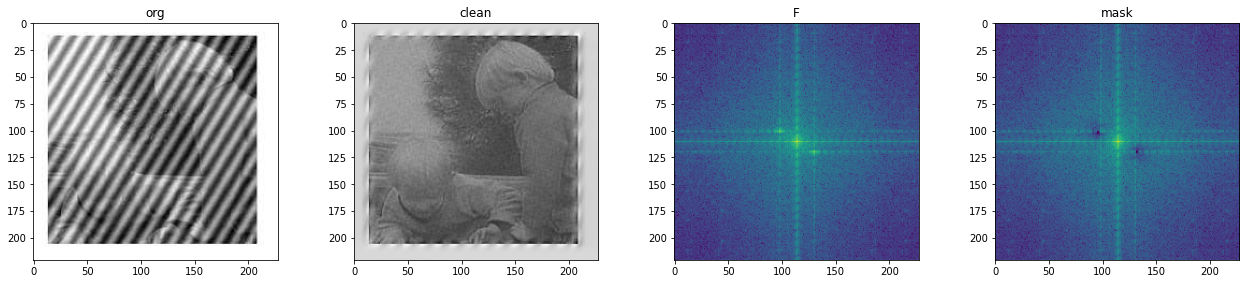

In [84]:
im = imread('images.jpg',as_gray=True)
imf = periodic_denosier(im, th=0.011, r=0.15, squer_size=40, nsig=2)

TODO: widmo, kernel gauss, log_rep 0 - 255